In [3303]:
import pandas as pd

df = pd.read_csv(r'https://raw.githubusercontent.com/4GeeksAcademy/logistic-regression-project-tutorial/main/bank-marketing-campaign-data.csv', delimiter=';')
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [3304]:
df[['y']].groupby('y').value_counts() #son muy pocas las personas en este dataframe que son target especifico de ofrecimiento de credito

y
no     36548
yes     4640
Name: count, dtype: int64

In [3305]:
df.shape

(41188, 21)

In [3306]:
df.rename(columns={'cons.price.idx': 'cons_price_idx'}, inplace=True)

In [3307]:
df.rename(columns={'cons.conf.idx': 'cons_conf_idx'}, inplace=True)

In [3308]:
df.rename(columns={'default': 'current_credit'}, inplace=True)

In [3309]:
df.rename(columns={'nr.employed': 'nr_employed'}, inplace=True)

In [3310]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   current_credit  41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons_price_idx  41188 non-null  float64
 17  cons_conf_idx   41188 non-null 

In [3311]:
df.nunique()
#debo revisar cual es la edad menor y la edad mayor disponible primero y establecer el rango de edad con la que es seguro trabajar, tener preferencia con la gente que tiene trabajo sea dependiente o independiente, que no tiene ningun tipo de deuda al momento o por lo menos no de housing.

age                 78
job                 12
marital              4
education            8
current_credit       3
housing              3
loan                 3
contact              2
month               10
day_of_week          5
duration          1544
campaign            42
pdays               27
previous             8
poutcome             3
emp.var.rate        10
cons_price_idx      26
cons_conf_idx       26
euribor3m          316
nr_employed         11
y                    2
dtype: int64

In [3312]:
df.drop(['marital', 'month', 'duration', 'campaign', 'previous', 'poutcome', 'pdays', 'contact', 'day_of_week', 'emp.var.rate'],axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)
df

,age,job,education,current_credit,housing,loan,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,56,housemaid,basic.4y,no,no,no,93.994,-36.4,4.857,5191.0,no
1,57,services,high.school,unknown,no,no,93.994,-36.4,4.857,5191.0,no
2,37,services,high.school,no,yes,no,93.994,-36.4,4.857,5191.0,no
3,40,admin.,basic.6y,no,no,no,93.994,-36.4,4.857,5191.0,no
4,56,services,high.school,no,no,yes,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,professional.course,no,yes,no,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,professional.course,no,no,no,94.767,-50.8,1.028,4963.6,no
41185,56,retired,university.degree,no,yes,no,94.767,-50.8,1.028,4963.6,no
41186,44,technician,professional.course,no,no,no,94.767,-50.8,1.028,4963.6,yes


In [3313]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,41188.0,40.024060,10.421250,17.000,32.000,38.000,47.000,98.000
cons_price_idx,41188.0,93.575664,0.578840,92.201,93.075,93.749,93.994,94.767
cons_conf_idx,41188.0,-40.502600,4.628198,-50.800,-42.700,-41.800,-36.400,-26.900
euribor3m,41188.0,3.621291,1.734447,0.634,1.344,4.857,4.961,5.045
nr_employed,41188.0,5167.035911,72.251528,4963.600,5099.100,5191.000,5228.100,5228.100


In [3314]:
df.isnull().mean()*100 #mi dataset no tiene datos Nan

age               0.0
job               0.0
education         0.0
current_credit    0.0
housing           0.0
loan              0.0
cons_price_idx    0.0
cons_conf_idx     0.0
euribor3m         0.0
nr_employed       0.0
y                 0.0
dtype: float64

In [3315]:
df.isna().sum()

age               0
job               0
education         0
current_credit    0
housing           0
loan              0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64

In [3316]:
#comienzo a filtrar primero por grupos de edad. Esto me indica que la edad minima es 17 y la maxima 98, el describe me indica que la medio por grupos percentiles de solo el 25% ya es de 32, y la del percentil 75 es de 47. 
#Con base en este informacion puedo delimitar el grupo de individuos cuya edad minima y maxima esten 5 unidades por encima y debajo de las medias de los cuartiles, es decir 25 y 62
age_population = df[['age']].groupby('age').value_counts()
age_population

age
17      5
18     28
19     42
20     65
21    102
     ... 
91      2
92      4
94      1
95      1
98      2
Name: count, Length: 78, dtype: int64

In [3317]:
filtro_edad = df.query('age >= 25 and age <=62')
filtro_edad #aqui mi base de datos se reduce pero no significativamente, ahora tengo un rango de edad mas adecuado para ofrecer un credito.

,age,job,education,current_credit,housing,loan,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,56,housemaid,basic.4y,no,no,no,93.994,-36.4,4.857,5191.0,no
1,57,services,high.school,unknown,no,no,93.994,-36.4,4.857,5191.0,no
2,37,services,high.school,no,yes,no,93.994,-36.4,4.857,5191.0,no
3,40,admin.,basic.6y,no,no,no,93.994,-36.4,4.857,5191.0,no
4,56,services,high.school,no,no,yes,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...
41181,37,admin.,university.degree,no,yes,no,94.767,-50.8,1.028,4963.6,yes
41182,29,unemployed,basic.4y,no,yes,no,94.767,-50.8,1.028,4963.6,no
41184,46,blue-collar,professional.course,no,no,no,94.767,-50.8,1.028,4963.6,no
41185,56,retired,university.degree,no,yes,no,94.767,-50.8,1.028,4963.6,no


In [3318]:
filtro_edad[['age']].groupby('age').value_counts() #ahora tengo una base de datos con informacion de grupos de edad un tanto mas significativa

age
25     598
26     698
27     851
28    1001
29    1453
30    1714
31    1947
32    1846
33    1833
34    1745
35    1759
36    1780
37    1475
38    1407
39    1432
40    1161
41    1278
42    1142
43    1055
44    1011
45    1103
46    1030
47     928
48     979
49     839
50     875
51     754
52     779
53     733
54     684
55     648
56     704
57     646
58     576
59     463
60     283
61      73
62      62
Name: count, dtype: int64

In [3319]:
filtro_edad[['job']].groupby('job').value_counts()

job
admin.           10240
blue-collar       9055
entrepreneur      1440
housemaid         1005
management        2878
retired           1092
self-employed     1406
services          3810
student            497
technician        6625
unemployed         990
unknown            307
Name: count, dtype: int64

In [3320]:
eliminar_trabajos = ['housemaid', 'unemployed', 'unknown', 'services']
gente_con_trabajo = filtro_edad[-filtro_edad['job'].isin(eliminar_trabajos)]
gente_con_trabajo #sigo manteniendo buen nivel de datos.
#sobreentiendo que el hecho de que tenga trabajo aumenta la probabilidad de que, al recibir una nueva oferta de prestamo, lo tome, despectivamente de que la variable y diga que no, pues, segun los datos completos
#del dataframe, supongo que es la respuesta a la ultima oferta, validar de nuevo puede dar un resultado positivo si las condiciones de la persona han cambiado

,age,job,education,current_credit,housing,loan,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
3,40,admin.,basic.6y,no,no,no,93.994,-36.4,4.857,5191.0,no
6,59,admin.,professional.course,no,no,no,93.994,-36.4,4.857,5191.0,no
7,41,blue-collar,unknown,unknown,no,no,93.994,-36.4,4.857,5191.0,no
10,41,blue-collar,unknown,unknown,no,no,93.994,-36.4,4.857,5191.0,no
12,29,blue-collar,high.school,no,no,yes,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...
41180,36,admin.,university.degree,no,no,no,94.767,-50.8,1.028,4963.6,no
41181,37,admin.,university.degree,no,yes,no,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,professional.course,no,no,no,94.767,-50.8,1.028,4963.6,no
41185,56,retired,university.degree,no,yes,no,94.767,-50.8,1.028,4963.6,no


In [3321]:
gente_con_trabajo[['job']].groupby('job').value_counts()#vuelvo a revisar para ver si los trabajos se eliminaron correctamente

job
admin.           10240
blue-collar       9055
entrepreneur      1440
management        2878
retired           1092
self-employed     1406
student            497
technician        6625
Name: count, dtype: int64

In [3322]:
unknown_default_cantidad = gente_con_trabajo[['current_credit']].groupby('current_credit').value_counts()
unknown_default_cantidad
#para continuar necesito convertir todos los valores de los tipos de credito a binario 0 para si 1 para no, por tanto los datos unknown me estorban. Comienzo por la variable del credito default

current_credit
no         26366
unknown     6865
yes            2
Name: count, dtype: int64

In [3323]:
eliminar_unknown = ['unknown']
gente_con_default = gente_con_trabajo[-gente_con_trabajo['current_credit'].isin(eliminar_unknown)]
gente_con_default

,age,job,education,current_credit,housing,loan,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
3,40,admin.,basic.6y,no,no,no,93.994,-36.4,4.857,5191.0,no
6,59,admin.,professional.course,no,no,no,93.994,-36.4,4.857,5191.0,no
12,29,blue-collar,high.school,no,no,yes,93.994,-36.4,4.857,5191.0,no
14,35,blue-collar,basic.6y,no,yes,no,93.994,-36.4,4.857,5191.0,no
16,35,blue-collar,basic.6y,no,yes,no,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...
41180,36,admin.,university.degree,no,no,no,94.767,-50.8,1.028,4963.6,no
41181,37,admin.,university.degree,no,yes,no,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,professional.course,no,no,no,94.767,-50.8,1.028,4963.6,no
41185,56,retired,university.degree,no,yes,no,94.767,-50.8,1.028,4963.6,no


In [3324]:
#Ahora reviso la variable housing
unknown_housing_cantidad = gente_con_trabajo[['housing']].groupby('housing').value_counts()
unknown_housing_cantidad #sigo teniendo datos inservibles por este lado, debo eliminarlos

housing
no         15064
unknown      780
yes        17389
Name: count, dtype: int64

In [3325]:
eliminar_unknown = ['unknown']
gente_con_housing = gente_con_default[-gente_con_default['housing'].isin(eliminar_unknown)]
gente_con_housing

,age,job,education,current_credit,housing,loan,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
3,40,admin.,basic.6y,no,no,no,93.994,-36.4,4.857,5191.0,no
6,59,admin.,professional.course,no,no,no,93.994,-36.4,4.857,5191.0,no
12,29,blue-collar,high.school,no,no,yes,93.994,-36.4,4.857,5191.0,no
14,35,blue-collar,basic.6y,no,yes,no,93.994,-36.4,4.857,5191.0,no
16,35,blue-collar,basic.6y,no,yes,no,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...
41180,36,admin.,university.degree,no,no,no,94.767,-50.8,1.028,4963.6,no
41181,37,admin.,university.degree,no,yes,no,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,professional.course,no,no,no,94.767,-50.8,1.028,4963.6,no
41185,56,retired,university.degree,no,yes,no,94.767,-50.8,1.028,4963.6,no


In [3326]:
#ahora reviso los de loan
unknown_housing_loan = gente_con_housing[['loan']].groupby('loan').value_counts()
unknown_housing_loan #aqui ya no tengo unknown.

loan
no     21715
yes     4050
Name: count, dtype: int64

In [3327]:
unknown_education = gente_con_housing[['education']].groupby('education').value_counts()
unknown_education

education
basic.4y               1674
basic.6y               1141
basic.9y               3588
high.school            5020
illiterate               11
professional.course    3825
university.degree      9713
unknown                 793
Name: count, dtype: int64

In [3328]:
eliminar_unknown_education = ['unknown', 'illiterate', 'basic.4y', 'basic.6y', 'basic.9y']
gente_con_education = gente_con_housing[-gente_con_housing['education'].isin(eliminar_unknown_education)]
gente_con_education #este tipo de educacion no es adecuado para obtener un loan del banco.

,age,job,education,current_credit,housing,loan,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
6,59,admin.,professional.course,no,no,no,93.994,-36.4,4.857,5191.0,no
12,29,blue-collar,high.school,no,no,yes,93.994,-36.4,4.857,5191.0,no
22,55,retired,high.school,no,yes,no,93.994,-36.4,4.857,5191.0,no
23,41,technician,high.school,no,yes,no,93.994,-36.4,4.857,5191.0,no
24,37,admin.,high.school,no,yes,no,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...
41180,36,admin.,university.degree,no,no,no,94.767,-50.8,1.028,4963.6,no
41181,37,admin.,university.degree,no,yes,no,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,professional.course,no,no,no,94.767,-50.8,1.028,4963.6,no
41185,56,retired,university.degree,no,yes,no,94.767,-50.8,1.028,4963.6,no


In [3329]:
#comienzo a convertir los datos de las variables necesarias a binario para poder procesarlas en el modelo
binary_jobs = gente_con_education

def get_binary_jobs(row):
    is_job = row['job']
    if is_job == 'admin.':
        return 0
    elif is_job == 'blue-collar':
        return 1
    elif is_job == 'entrepreneur':
        return 2
    elif is_job == 'management':
        return 3
    elif is_job == 'retired':
        return 4
    elif is_job == 'self-employed':
        return 5
    elif is_job == 'technician':
        return 6
    elif is_job == 'student':
        return 7
    
binary_jobs['job'] = binary_jobs.apply(get_binary_jobs, axis=1)
binary_jobs

/tmp/ipykernel_24852/1755378166.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binary_jobs['job'] = binary_jobs.apply(get_binary_jobs, axis=1)


,age,job,education,current_credit,housing,loan,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
6,59,0,professional.course,no,no,no,93.994,-36.4,4.857,5191.0,no
12,29,1,high.school,no,no,yes,93.994,-36.4,4.857,5191.0,no
22,55,4,high.school,no,yes,no,93.994,-36.4,4.857,5191.0,no
23,41,6,high.school,no,yes,no,93.994,-36.4,4.857,5191.0,no
24,37,0,high.school,no,yes,no,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...
41180,36,0,university.degree,no,no,no,94.767,-50.8,1.028,4963.6,no
41181,37,0,university.degree,no,yes,no,94.767,-50.8,1.028,4963.6,yes
41184,46,1,professional.course,no,no,no,94.767,-50.8,1.028,4963.6,no
41185,56,4,university.degree,no,yes,no,94.767,-50.8,1.028,4963.6,no


In [3330]:
binary_education = binary_jobs

binary_education[['education']].groupby('education').value_counts()

education
high.school            5020
professional.course    3825
university.degree      9713
Name: count, dtype: int64

In [3331]:
# Reemplazar los puntos por guiones bajos en la columna 'education'
binary_education['education'] = binary_education['education'].str.replace('.', '_')
binary_education

/tmp/ipykernel_24852/1818093813.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binary_education['education'] = binary_education['education'].str.replace('.', '_')


,age,job,education,current_credit,housing,loan,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
6,59,0,professional_course,no,no,no,93.994,-36.4,4.857,5191.0,no
12,29,1,high_school,no,no,yes,93.994,-36.4,4.857,5191.0,no
22,55,4,high_school,no,yes,no,93.994,-36.4,4.857,5191.0,no
23,41,6,high_school,no,yes,no,93.994,-36.4,4.857,5191.0,no
24,37,0,high_school,no,yes,no,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...
41180,36,0,university_degree,no,no,no,94.767,-50.8,1.028,4963.6,no
41181,37,0,university_degree,no,yes,no,94.767,-50.8,1.028,4963.6,yes
41184,46,1,professional_course,no,no,no,94.767,-50.8,1.028,4963.6,no
41185,56,4,university_degree,no,yes,no,94.767,-50.8,1.028,4963.6,no


In [3332]:
binary_education = binary_jobs.copy()
def get_education(row):
    is_educated = row['education']
    if is_educated == 'high_school':
        return 0
    elif is_educated == 'professional_course':
        return 1
    elif is_educated == 'university_degree':
        return 2
    
binary_education['education'] = binary_education.apply(get_education, axis=1)
binary_education

,age,job,education,current_credit,housing,loan,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
6,59,0,1,no,no,no,93.994,-36.4,4.857,5191.0,no
12,29,1,0,no,no,yes,93.994,-36.4,4.857,5191.0,no
22,55,4,0,no,yes,no,93.994,-36.4,4.857,5191.0,no
23,41,6,0,no,yes,no,93.994,-36.4,4.857,5191.0,no
24,37,0,0,no,yes,no,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...
41180,36,0,2,no,no,no,94.767,-50.8,1.028,4963.6,no
41181,37,0,2,no,yes,no,94.767,-50.8,1.028,4963.6,yes
41184,46,1,1,no,no,no,94.767,-50.8,1.028,4963.6,no
41185,56,4,2,no,yes,no,94.767,-50.8,1.028,4963.6,no


In [3333]:
#ahora procedo a reemplazar los valores yes o no por 0 y 1
gente_con_default = binary_education
def get_default(row):
    is_default = row['current_credit']
    if is_default == 'no':
        return 0
    elif is_default == 'yes':
        return 1
    
gente_con_default['current_credit'] = gente_con_default.apply(get_default, axis=1)
gente_con_default

,age,job,education,current_credit,housing,loan,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
6,59,0,1,0,no,no,93.994,-36.4,4.857,5191.0,no
12,29,1,0,0,no,yes,93.994,-36.4,4.857,5191.0,no
22,55,4,0,0,yes,no,93.994,-36.4,4.857,5191.0,no
23,41,6,0,0,yes,no,93.994,-36.4,4.857,5191.0,no
24,37,0,0,0,yes,no,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...
41180,36,0,2,0,no,no,94.767,-50.8,1.028,4963.6,no
41181,37,0,2,0,yes,no,94.767,-50.8,1.028,4963.6,yes
41184,46,1,1,0,no,no,94.767,-50.8,1.028,4963.6,no
41185,56,4,2,0,yes,no,94.767,-50.8,1.028,4963.6,no


In [3334]:
binary_housing = gente_con_default

def get_housing(row):
    is_housing = row['housing']
    if is_housing == 'no':
        return 0
    elif is_housing == 'yes':
        return 1
    
binary_housing['housing'] = binary_housing.apply(get_housing, axis=1)
binary_housing

,age,job,education,current_credit,housing,loan,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
6,59,0,1,0,0,no,93.994,-36.4,4.857,5191.0,no
12,29,1,0,0,0,yes,93.994,-36.4,4.857,5191.0,no
22,55,4,0,0,1,no,93.994,-36.4,4.857,5191.0,no
23,41,6,0,0,1,no,93.994,-36.4,4.857,5191.0,no
24,37,0,0,0,1,no,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...
41180,36,0,2,0,0,no,94.767,-50.8,1.028,4963.6,no
41181,37,0,2,0,1,no,94.767,-50.8,1.028,4963.6,yes
41184,46,1,1,0,0,no,94.767,-50.8,1.028,4963.6,no
41185,56,4,2,0,1,no,94.767,-50.8,1.028,4963.6,no


In [3335]:
binary_loan = binary_housing

def get_loan(row):
    is_loan = row['loan']
    if is_loan == 'no':
        return 0
    elif is_loan == 'yes':
        return 1
    
binary_loan['loan'] = binary_loan.apply(get_loan, axis=1)
binary_loan

,age,job,education,current_credit,housing,loan,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
6,59,0,1,0,0,0,93.994,-36.4,4.857,5191.0,no
12,29,1,0,0,0,1,93.994,-36.4,4.857,5191.0,no
22,55,4,0,0,1,0,93.994,-36.4,4.857,5191.0,no
23,41,6,0,0,1,0,93.994,-36.4,4.857,5191.0,no
24,37,0,0,0,1,0,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...
41180,36,0,2,0,0,0,94.767,-50.8,1.028,4963.6,no
41181,37,0,2,0,1,0,94.767,-50.8,1.028,4963.6,yes
41184,46,1,1,0,0,0,94.767,-50.8,1.028,4963.6,no
41185,56,4,2,0,1,0,94.767,-50.8,1.028,4963.6,no


In [3336]:
binary_target = binary_loan

def get_target(row):
    is_target = row['y']
    if is_target == 'no':
        return 0
    elif is_target == 'yes':
        return 1
    
binary_target['y'] = binary_target.apply(get_target, axis=1)
binary_target

,age,job,education,current_credit,housing,loan,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
6,59,0,1,0,0,0,93.994,-36.4,4.857,5191.0,0
12,29,1,0,0,0,1,93.994,-36.4,4.857,5191.0,0
22,55,4,0,0,1,0,93.994,-36.4,4.857,5191.0,0
23,41,6,0,0,1,0,93.994,-36.4,4.857,5191.0,0
24,37,0,0,0,1,0,93.994,-36.4,4.857,5191.0,0
...,...,...,...,...,...,...,...,...,...,...,...
41180,36,0,2,0,0,0,94.767,-50.8,1.028,4963.6,0
41181,37,0,2,0,1,0,94.767,-50.8,1.028,4963.6,1
41184,46,1,1,0,0,0,94.767,-50.8,1.028,4963.6,0
41185,56,4,2,0,1,0,94.767,-50.8,1.028,4963.6,0


In [3337]:
binary_target[['y']].groupby('y').value_counts() #no hay unknown en esta variable y todavia conservamos buena parte de los target originales del dataframe

y
0    16119
1     2439
Name: count, dtype: int64

In [3338]:
filtered_df = binary_target
sesgo = filtered_df.apply(lambda x: x.skew())
sesgo #hay un sesgo extremadamente negativo en default, lo cual no es normal, ya que el sesgo comun es de -2 a 2, debo revisar esa columna para establecer el porque de estos datos

age                0.712016
job                0.352855
education         -0.508442
current_credit    96.319779
housing           -0.183125
loan               1.863384
cons_price_idx    -0.077810
cons_conf_idx      0.246419
euribor3m         -0.598090
nr_employed       -0.961616
y                  2.181957
dtype: float64

In [3339]:
filtered_df[['current_credit']].groupby('current_credit').value_counts() #esto me muestra la razon del sesgo negativo extremadamente alto y es por que hay una distribucion de datos desequilibrada, pero esto no significa un problema para continuar con el eda.
#este valor en fault muestra que entre el grupo de datos, solo dos personas tienes producto tipo default.

current_credit
0    18556
1        2
Name: count, dtype: int64

In [3340]:
confianza_con_housing = filtered_df.copy()
housing_0 = confianza_con_housing[confianza_con_housing['housing'] == 1]
housing_0 #filtrar el df con todos los que tienen credito hipotecario, representa casi una tercera parte del df original y se ve una variacion de la confianza mas negativa, dado que la negativa mas baja es -26, ya llegando aqui
#no necesito mucho mas de las variables iniciales, ya que tengo un grupo de datos de gente con mayor similitud 

,age,job,education,current_credit,housing,loan,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
22,55,4,0,0,1,0,93.994,-36.4,4.857,5191.0,0
23,41,6,0,0,1,0,93.994,-36.4,4.857,5191.0,0
24,37,0,0,0,1,0,93.994,-36.4,4.857,5191.0,0
38,41,0,2,0,1,0,93.994,-36.4,4.857,5191.0,0
40,58,3,2,0,1,0,93.994,-36.4,4.857,5191.0,0
...,...,...,...,...,...,...,...,...,...,...,...
41173,62,4,2,0,1,0,94.767,-50.8,1.031,4963.6,1
41174,62,4,2,0,1,0,94.767,-50.8,1.031,4963.6,1
41177,57,4,1,0,1,0,94.767,-50.8,1.031,4963.6,0
41181,37,0,2,0,1,0,94.767,-50.8,1.028,4963.6,1


In [3341]:
import statsmodels.api as sm
# Variables independientes/dependiente
X = housing_0.drop(['y'], axis=1)
y = housing_0['y']

# Ajusta el modelo
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# Instancia de la influencia y obtención de la distancia de cook para cada observación
cooks_distance = model.get_influence().cooks_distance

/home/vscode/.local/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:848: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)


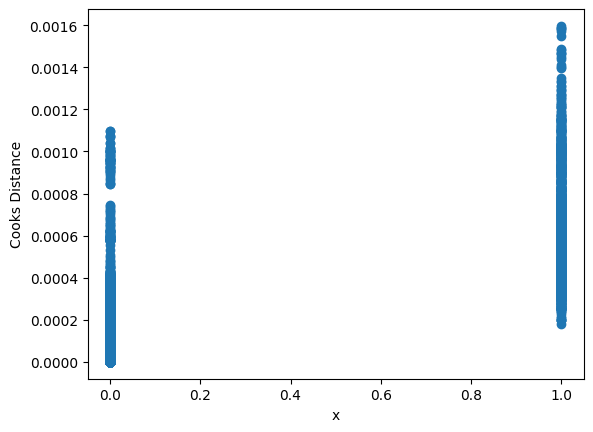

In [3342]:
import matplotlib.pyplot as plt

plt.scatter(housing_0.y, cooks_distance[0])
plt.xlabel('x')
plt.ylabel('Cooks Distance')
plt.show()

In [3343]:
housing_0[['cons_conf_idx']].groupby('cons_conf_idx').value_counts() #esto me muestra que la mayoria de las personas disponibles tienen un indice de confianza bajo, pero debido a que la investigacion va de que sujetos son mas propensos a aceptar un credito
#todavia esto no especifica que no lo vayan  a aceptar, como dije antes, todavia esta la variable de si tienen creditos y de que tipo y condiciones de pago, bien su indice de confianza podria deberse a problemas para pagar las cuotas de alguno de ellos.

cons_conf_idx
-50.8      49
-50.0     114
-49.5      61
-47.1     644
-46.2    1461
-45.9       5
-42.7    1372
-42.0    1207
-41.8     669
-40.8     270
-40.4      24
-40.3      93
-40.0      58
-39.8      77
-38.3      65
-37.5      91
-36.4    1250
-36.1    1805
-34.8      86
-34.6      57
-33.6      70
-33.0      48
-31.4     230
-30.1     111
-29.8      91
-26.9     117
Name: count, dtype: int64

In [3344]:
housing_0.drop(['housing'], inplace=True, axis=1)
housing_0.reset_index(drop=True, inplace=True)
housing_0

/tmp/ipykernel_24852/3146377956.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_0.drop(['housing'], inplace=True, axis=1)


,age,job,education,current_credit,loan,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,55,4,0,0,0,93.994,-36.4,4.857,5191.0,0
1,41,6,0,0,0,93.994,-36.4,4.857,5191.0,0
2,37,0,0,0,0,93.994,-36.4,4.857,5191.0,0
3,41,0,2,0,0,93.994,-36.4,4.857,5191.0,0
4,58,3,2,0,0,93.994,-36.4,4.857,5191.0,0
...,...,...,...,...,...,...,...,...,...,...
10120,62,4,2,0,0,94.767,-50.8,1.031,4963.6,1
10121,62,4,2,0,0,94.767,-50.8,1.031,4963.6,1
10122,57,4,1,0,0,94.767,-50.8,1.031,4963.6,0
10123,37,0,2,0,0,94.767,-50.8,1.028,4963.6,1


In [3345]:
housing_0[['y']].groupby('y').value_counts() #de 4600 personas que eran originalmente target, aqui tengo aun casi 1022, casi una cuarta parte de eso. Estos filtros me sirven para buscar nuevos prospectos con caracteristicas similares a los target
#En este caso, buena parte de los target tienen credito hipotecario, tienen trabajos un tanto mas estables

y
0    8766
1    1359
Name: count, dtype: int64

In [3346]:
# Calcular el monto máximo del préstamo usando los valores de euribor3m como coeficientes
housing_0['max_loan_amount'] = (housing_0['euribor3m'] * abs(housing_0['cons_conf_idx']) * housing_0['cons_price_idx']).round()
housing_0#es apenas una base que puede servir al crear la oferta real, ahora necesito comenzar a costruir el modelo de regresion logistica para saber la probabilidad de que la persona acepte o no la oferta.

/tmp/ipykernel_24852/3736705244.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_0['max_loan_amount'] = (housing_0['euribor3m'] * abs(housing_0['cons_conf_idx']) * housing_0['cons_price_idx']).round()


,age,job,education,current_credit,loan,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y,max_loan_amount
0,55,4,0,0,0,93.994,-36.4,4.857,5191.0,0,16618.0
1,41,6,0,0,0,93.994,-36.4,4.857,5191.0,0,16618.0
2,37,0,0,0,0,93.994,-36.4,4.857,5191.0,0,16618.0
3,41,0,2,0,0,93.994,-36.4,4.857,5191.0,0,16618.0
4,58,3,2,0,0,93.994,-36.4,4.857,5191.0,0,16618.0
...,...,...,...,...,...,...,...,...,...,...,...
10120,62,4,2,0,0,94.767,-50.8,1.031,4963.6,1,4963.0
10121,62,4,2,0,0,94.767,-50.8,1.031,4963.6,1,4963.0
10122,57,4,1,0,0,94.767,-50.8,1.031,4963.6,0,4963.0
10123,37,0,2,0,0,94.767,-50.8,1.028,4963.6,1,4949.0


In [3347]:
housing_0[['cons_conf_idx']].groupby('cons_conf_idx').value_counts() #esto demuestra que aunque hay precencia de los indices de confianza mas cercanos al 0 de todos modos la mayoria de la poblacion tiene un indice de confianza bastante negativo
#necesito variables que representen el monto del prestamo, la cuota mensual a tantos meses y su valor con interes segun euribor.

cons_conf_idx
-50.8      49
-50.0     114
-49.5      61
-47.1     644
-46.2    1461
-45.9       5
-42.7    1372
-42.0    1207
-41.8     669
-40.8     270
-40.4      24
-40.3      93
-40.0      58
-39.8      77
-38.3      65
-37.5      91
-36.4    1250
-36.1    1805
-34.8      86
-34.6      57
-33.6      70
-33.0      48
-31.4     230
-30.1     111
-29.8      91
-26.9     117
Name: count, dtype: int64

In [3348]:
def calculate_monthly_payment_with_interest(max_loan_amount, term, euribor3m):
    monthly_interest = max_loan_amount * (euribor3m / 12)
    total_monthly_payment = (max_loan_amount + monthly_interest) / term
    return total_monthly_payment

#pagos mensuales a capital sin interes
housing_0['installment_12_min'] = housing_0['max_loan_amount'] // 12
housing_0['installment_24_min'] = housing_0['max_loan_amount'] // 24
housing_0['installment_36_min'] = housing_0['max_loan_amount'] // 36
#pagos mensuales 
housing_0['first_payment_with_interest_12'] = housing_0.apply(lambda row: calculate_monthly_payment_with_interest(row['max_loan_amount'], 12, row['euribor3m']), axis=1).round()
housing_0['first_payment_with_interest_24'] = housing_0.apply(lambda row: calculate_monthly_payment_with_interest(row['max_loan_amount'], 24, row['euribor3m']), axis=1).round()
housing_0['first_payment_with_interest_36'] = housing_0.apply(lambda row: calculate_monthly_payment_with_interest(row['max_loan_amount'], 36, row['euribor3m']), axis=1).round()

# Crear una nueva columna que represente la relación entre la edad y la cantidad del préstamo
housing_0['age_loan_ratio'] = (housing_0['age'] / housing_0['max_loan_amount'])*100
# Crear una nueva columna que combine el tipo de trabajo y la variable objetivo
housing_0['job_y'] = housing_0['job'].astype(str) + '_' + housing_0['y'].astype(str)
# Crear una columna que represente la proporción de empleados por tipo de trabajo
housing_0['employees_per_job'] = housing_0.groupby('job')['nr_employed'].transform('mean')
# Calcular la diferencia entre nr_employed y euribor3m para ver si el numero de empleados esta relacionado con las tasas de interes disponibles
# Calcular el precio medio del euribor por cada tipo de trabajo
average_euribor_per_job = housing_0.groupby('job')['euribor3m'].mean()
# Crear una columna que represente la diferencia entre euribor3m y el precio medio del euribor por cada tipo de trabajo
housing_0['euribor_diff_to_avg'] = housing_0['euribor3m'] - housing_0['job'].map(average_euribor_per_job)
# Calcular el promedio de nr_employed para cada nivel de cons_conf_idx y ver si hay una regla de disatisfaccion con relacion a la empresa.
housing_0['avg_employed_per_conf_idx'] = housing_0.groupby('cons_conf_idx')['nr_employed'].transform('mean')


housing_0 #establezco un termino imaginario para establecer la oferta con el cliente, y no adiciono columnas adicionales que muestren el pago final porque el sistema bancario europeo no ofrece tasa fija en plazo fijo
#entonces los intereses pueden aumentar como pueden bajar a lo largo del tiempo, por tanto estas nuevas columnas solo contemplan el valor del primer pago, de el cliente aceptar el prestamo, con el precio del euribor actual.

/tmp/ipykernel_24852/2184021304.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_0['installment_12_min'] = housing_0['max_loan_amount'] // 12
/tmp/ipykernel_24852/2184021304.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_0['installment_24_min'] = housing_0['max_loan_amount'] // 24
/tmp/ipykernel_24852/2184021304.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

/tmp/ipykernel_24852/2184021304.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_0['first_payment_with_interest_12'] = housing_0.apply(lambda row: calculate_monthly_payment_with_interest(row['max_loan_amount'], 12, row['euribor3m']), axis=1).round()
/tmp/ipykernel_24852/2184021304.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_0['first_payment_with_interest_24'] = housing_0.apply(lambda row: calculate_monthly_payment_with_interest(row['max_loan_amount'], 24, row['euribor3m']), axis

,age,job,education,current_credit,loan,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y,...,installment_24_min,installment_36_min,first_payment_with_interest_12,first_payment_with_interest_24,first_payment_with_interest_36,age_loan_ratio,job_y,employees_per_job,euribor_diff_to_avg,avg_employed_per_conf_idx
0,55,4,0,0,0,93.994,-36.4,4.857,5191.0,0,...,692.0,461.0,1945.0,973.0,648.0,0.330966,4_0,5152.809787,1.580153,5191.0
1,41,6,0,0,0,93.994,-36.4,4.857,5191.0,0,...,692.0,461.0,1945.0,973.0,648.0,0.246720,6_0,5171.261091,1.180868,5191.0
2,37,0,0,0,0,93.994,-36.4,4.857,5191.0,0,...,692.0,461.0,1945.0,973.0,648.0,0.222650,0_0,5155.090068,1.542719,5191.0
3,41,0,2,0,0,93.994,-36.4,4.857,5191.0,0,...,692.0,461.0,1945.0,973.0,648.0,0.246720,0_0,5155.090068,1.542719,5191.0
4,58,3,2,0,0,93.994,-36.4,4.857,5191.0,0,...,692.0,461.0,1945.0,973.0,648.0,0.349019,3_0,5159.766792,1.442403,5191.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10120,62,4,2,0,0,94.767,-50.8,1.031,4963.6,1,...,206.0,137.0,449.0,225.0,150.0,1.249244,4_1,5152.809787,-2.245847,4963.6
10121,62,4,2,0,0,94.767,-50.8,1.031,4963.6,1,...,206.0,137.0,449.0,225.0,150.0,1.249244,4_1,5152.809787,-2.245847,4963.6
10122,57,4,1,0,0,94.767,-50.8,1.031,4963.6,0,...,206.0,137.0,449.0,225.0,150.0,1.148499,4_0,5152.809787,-2.245847,4963.6
10123,37,0,2,0,0,94.767,-50.8,1.028,4963.6,1,...,206.0,137.0,448.0,224.0,149.0,0.747626,0_1,5155.090068,-2.286281,4963.6


#Trabajos disponibles:

admin.            0
blue-collar       1
entrepreneur      2
management        3
retired           4
self-employed     5
technician        6

In [3349]:
#al principio queria filtrar fuera las personas que tenian creditos de housing, pero como no se que tipo de condiciones tiene el credito que el banco esta queriendo ofrecer, a lo mejor, si las condiciones son mejores que las del credito
#hipotecario, podria ser un factor que haga a la gente aceptar el credito, entonces dejo esa variable intacta.
import seaborn as sns
import matplotlib.pyplot as plt

# Calcula la matriz de correlación
corr= housing_0.corr()

# Crea el mapa de correlación 
corr.style.background_gradient(cmap='coolwarm').format(precision=3)#tuve que eliminar la variable housing ya que al tener un valor constante estaba causando problemas en el modelo con valores nan
#aqui tengo una correlacion bien construida con las nuevas variables, entonces continuo entrenando el modelo.

,age,job,education,current_credit,loan,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y,max_loan_amount,installment_12_min,installment_24_min,installment_36_min,first_payment_with_interest_12,first_payment_with_interest_24,first_payment_with_interest_36,age_loan_ratio,job_y,employees_per_job,euribor_diff_to_avg,avg_employed_per_conf_idx
age,1.000,0.017,0.005,0.011,-0.008,0.010,0.053,0.038,0.028,0.000,0.034,0.034,0.034,0.034,0.034,0.034,0.034,0.249,0.017,0.082,0.028,0.028
job,0.017,1.000,-0.009,0.013,-0.028,0.011,0.032,0.059,0.057,-0.014,0.048,0.048,0.048,0.048,0.049,0.049,0.049,-0.045,1.000,0.393,-0.000,0.057
education,0.005,-0.009,1.000,-0.003,0.005,-0.050,0.087,-0.004,-0.012,0.021,-0.020,-0.020,-0.020,-0.020,-0.018,-0.018,-0.018,0.033,-0.009,0.024,-0.009,-0.012
current_credit,0.011,0.013,-0.003,1.000,-0.005,-0.000,0.009,0.009,0.009,-0.004,0.006,0.006,0.006,0.006,0.007,0.007,0.007,-0.004,0.013,0.010,0.007,0.009
loan,-0.008,-0.028,0.005,-0.005,1.000,0.005,-0.014,0.004,0.007,-0.013,0.005,0.005,0.005,0.005,0.005,0.005,0.005,-0.010,-0.028,-0.015,0.006,0.007
cons_price_idx,0.010,0.011,-0.050,-0.000,0.005,1.000,0.000,0.617,0.429,-0.110,0.639,0.639,0.639,0.639,0.648,0.648,0.648,-0.476,0.010,0.014,0.620,0.429
cons_conf_idx,0.053,0.032,0.087,0.009,-0.014,0.000,1.000,0.255,0.107,0.034,0.117,0.117,0.117,0.117,0.155,0.155,0.155,0.251,0.033,0.042,0.250,0.107
euribor3m,0.038,0.059,-0.004,0.009,0.004,0.617,0.255,1.000,0.948,-0.325,0.984,0.984,0.983,0.984,0.988,0.988,0.988,-0.770,0.054,0.131,0.991,0.948
nr_employed,0.028,0.057,-0.012,0.009,0.007,0.429,0.107,0.948,1.000,-0.370,0.951,0.951,0.951,0.951,0.948,0.948,0.948,-0.813,0.052,0.145,0.937,1.000
y,0.000,-0.014,0.021,-0.004,-0.013,-0.110,0.034,-0.325,-0.370,1.000,-0.329,-0.329,-0.329,-0.329,-0.323,-0.323,-0.323,0.344,-0.001,-0.063,-0.320,-0.370


In [3350]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.Series([variance_inflation_factor(corr.values, i) for i in range(corr.shape[1])], index=housing_0.columns)
vif #multicolinealidad alta

/home/vscode/.local/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


age                               7.387838e+03
job                                        inf
education                         5.158224e+03
current_credit                    1.568239e+03
loan                              6.072862e+03
cons_price_idx                    4.976773e+06
cons_conf_idx                     1.780930e+06
euribor3m                         1.982137e+09
nr_employed                                inf
y                                          inf
max_loan_amount                   3.916174e+14
installment_12_min                6.004800e+14
installment_24_min                4.393756e+13
installment_36_min                7.758139e+12
first_payment_with_interest_12    1.185158e+14
first_payment_with_interest_24    4.842580e+13
first_payment_with_interest_36    3.127500e+13
age_loan_ratio                    2.950758e+06
job_y                                      inf
employees_per_job                 3.990214e+06
euribor_diff_to_avg               1.828212e+09
avg_employed_

In [3351]:
housing_0.reset_index(drop=True, inplace=True)
new_df_cleaned = housing_0.copy()
new_df_cleaned.drop(['installment_36_min', 'first_payment_with_interest_36'], axis=1, inplace=True)
new_df_cleaned

,age,job,education,current_credit,loan,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y,max_loan_amount,installment_12_min,installment_24_min,first_payment_with_interest_12,first_payment_with_interest_24,age_loan_ratio,job_y,employees_per_job,euribor_diff_to_avg,avg_employed_per_conf_idx
0,55,4,0,0,0,93.994,-36.4,4.857,5191.0,0,16618.0,1384.0,692.0,1945.0,973.0,0.330966,4_0,5152.809787,1.580153,5191.0
1,41,6,0,0,0,93.994,-36.4,4.857,5191.0,0,16618.0,1384.0,692.0,1945.0,973.0,0.246720,6_0,5171.261091,1.180868,5191.0
2,37,0,0,0,0,93.994,-36.4,4.857,5191.0,0,16618.0,1384.0,692.0,1945.0,973.0,0.222650,0_0,5155.090068,1.542719,5191.0
3,41,0,2,0,0,93.994,-36.4,4.857,5191.0,0,16618.0,1384.0,692.0,1945.0,973.0,0.246720,0_0,5155.090068,1.542719,5191.0
4,58,3,2,0,0,93.994,-36.4,4.857,5191.0,0,16618.0,1384.0,692.0,1945.0,973.0,0.349019,3_0,5159.766792,1.442403,5191.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10120,62,4,2,0,0,94.767,-50.8,1.031,4963.6,1,4963.0,413.0,206.0,449.0,225.0,1.249244,4_1,5152.809787,-2.245847,4963.6
10121,62,4,2,0,0,94.767,-50.8,1.031,4963.6,1,4963.0,413.0,206.0,449.0,225.0,1.249244,4_1,5152.809787,-2.245847,4963.6
10122,57,4,1,0,0,94.767,-50.8,1.031,4963.6,0,4963.0,413.0,206.0,449.0,225.0,1.148499,4_0,5152.809787,-2.245847,4963.6
10123,37,0,2,0,0,94.767,-50.8,1.028,4963.6,1,4949.0,412.0,206.0,448.0,224.0,0.747626,0_1,5155.090068,-2.286281,4963.6


In [3352]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score#

# Supongamos que X son tus variables predictoras y y es tu variable objetivo
X = new_df_cleaned.drop(['y'], axis=1)  # Eliminar la variable objetivo del conjunto de datos
y = new_df_cleaned['y']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenar el modelo de regresión logística
logistic_model = LogisticRegression()
logistic_model.fit(X_train_scaled, y_train)

# Evaluar el modelo
accuracy = logistic_model.score(X_test_scaled, y_test)
print("Accuracy:", accuracy*100)
#un 90% de probabilidad de que los prospecto seleccionados, bajo los terminos que se han propuesto, acepten el prestamo
#voy a revisar las metricas de evaluacion de clasificacion

Accuracy: 90.71604938271605


In [3353]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_predict

# Obtener las predicciones del modelo en los datos de prueba
y_pred = logistic_model.predict(X_test_scaled)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:")
print(conf_matrix)
#TN: 1736
#FP: 0
#FN: 188
#VP: 101

Matriz de confusión:
[[1736    0]
 [ 188  101]]


In [3355]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calcular la precisión
precision = precision_score(y_test, y_pred)

# Calcular el recall
recall = recall_score(y_test, y_pred)

# Calcular el F1-score
f1 = f1_score(y_test, y_pred)

print("Precisión:", precision*100) #las muestras que fueron correctas entre todas las predicciones positivas
print("Recall:", recall*100) #sensibilidad del modelo y las muestras que fueron clasificadas correctamente entre todas las muestras positivas reales
print("F1-score:", f1*100) #media entre las dos anteriores

Precisión: 100.0
Recall: 34.94809688581315
F1-score: 51.7948717948718


datos iniciales:
Precisión: 51.28205128205128
Recall: 8.403361344537815
F1-score: 14.440433212996389